In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
''' MNIST consists of grayscale images with a size of 28x28,
but since UNet++ is designed to handle larger images,
the images are resized (e.g., to 128x128) before being used.'''

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 12.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 362kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 2.74MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.87MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



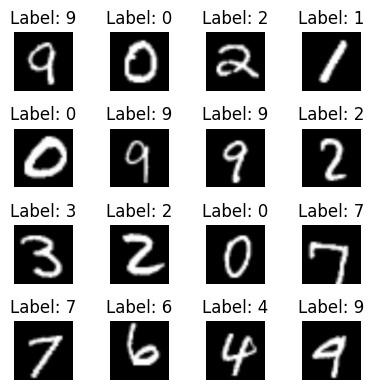

Image shape: torch.Size([1, 128, 128])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def show_image_grid(images, labels, num_images):
    rows = int(np.sqrt(num_images))
    cols = rows

    plt.figure(figsize=(4, 4))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title(f'Label: {labels[i]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

show_image_grid(images[:16], labels[:16], 16)

print(f"Image shape: {images[0].shape}")

In [ ]:
def upsample(x, target_size):
    """
    Performs bilinear upsampling to match the target size.

    Parameters:
        x (torch.Tensor): The input tensor to be upsampled.
        target_size (tuple): The target height and width for the upsampled tensor.

    Returns:
        torch.Tensor: The upsampled tensor.

    Example:
        >>> x = torch.randn(1, 64, 32, 32)  # Input tensor with shape [batch_size, channels, height, width]
        >>> target_size = (64, 64)
        >>> out = upsample(x, target_size)
        >>> print(out.shape)  # Output shape: [1, 64, 64, 64]
    """
    return F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)

class ConvBlock(nn.Module):
    """
    A basic convolutional block consisting of two convolutional layers followed by ReLU activations.

    Parameters:
        in_channels (int): Number of input channels.
        out_channels (int): Number of output channels.

    Example:
        >>> block = ConvBlock(in_channels=3, out_channels=64)
        >>> x = torch.randn(1, 3, 128, 128)  # Input tensor [batch_size, channels, height, width]
        >>> out = block(x)
        >>> print(out.shape)  # Output shape: [1, 64, 128, 128]
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

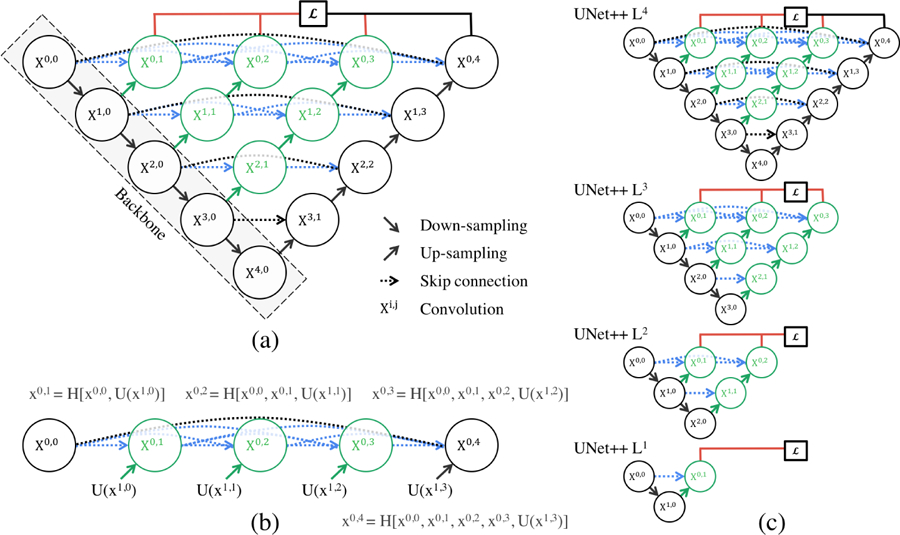

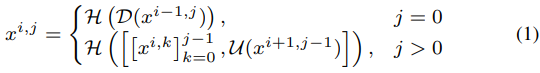

In [ ]:
class UNetPlusPlus(nn.Module):
    """
    UNet++ architecture implementation for image segmentation tasks.

    This class implements the UNet++ architecture with nested dense skip connections,
    as described in Equation (1) of the UNet++ paper. The network is designed for
    segmentation tasks but is adjusted here for MNIST classification.

    Parameters:
        in_channels (int): Number of input channels (e.g., grayscale=1, RGB=3).
        out_channels (int): Number of output channels (e.g., number of classes).
        base_filters (int): Number of filters in the first layer (default: 32).

    Example:
        >>> model = UNetPlusPlus(in_channels=1, out_channels=10)
        >>> x = torch.randn(1, 1, 128, 128)  # Input tensor [batch_size, channels, height, width]
        >>> out = model(x)
        >>> print(out.shape)  # Output shape: [1, 10, 128, 128]
    """
    def __init__(self, in_channels=1, out_channels=10, base_filters=32):
        super(UNetPlusPlus, self).__init__()

        # Defines the encoder path to extract features at multiple resolutions.
        # Each encoder block consists of two convolutional layers followed by ReLU activations (ConvBlock).
        # Filters are doubled at each level to capture more complex features.
        # (a) backborn
        # Example:
        # Input: [batch_size, in_channels=1, height=128, width=128]
        # After enc1: [batch_size, base_filters=32, height=128, width=128]
        # After enc2: [batch_size, base_filters*2=64, height=64, width=64] (downsampled by pooling).
        self.enc1 = ConvBlock(in_channels, base_filters)          # x^{0,0}
        self.enc2 = ConvBlock(base_filters, base_filters * 2)     # x^{1,0}
        self.enc3 = ConvBlock(base_filters * 2, base_filters * 4) # x^{2,0}
        self.enc4 = ConvBlock(base_filters * 4, base_filters * 8) # x^{3,0}

        # Defines the decoder path for the first level (j=1) using skip connections.
        # Each decoder block combines features from the encoder and upsampled features from deeper layers.
        # Filters are reduced as we move up the decoder path.
        self.dec1_1 = ConvBlock(base_filters + base_filters * 2, base_filters)          # x^{0,1}
        self.dec2_1 = ConvBlock(base_filters * 2 + base_filters * 4, base_filters * 2)  # x^{1,1}
        self.dec3_1 = ConvBlock(base_filters * 4 + base_filters * 8, base_filters * 4)  # x^{2,1}

        # Adds nested dense skip connections for level j=2, combining outputs from level j=1.
        self.dec1_2 = ConvBlock(base_filters + base_filters + base_filters * 2, base_filters)             # x^{0,2}
        self.dec2_2 = ConvBlock(base_filters * 2 + base_filters * 2 + base_filters * 4, base_filters * 2) # x^{1,2}

        # Adds another nested dense skip connection for level j=3.
        self.dec1_3 = ConvBlock(base_filters + base_filters + base_filters + base_filters * 2, base_filters) # x^{0,3}

        # Reduces the number of channels to match the required number of output classes (out_channels).
        # Kernel size of 1x1 ensures no spatial reduction.
        self.final = nn.Conv2d(base_filters, out_channels, kernel_size=1)

        # Downsamples feature maps by a factor of 2 in both height and width.
        # Used in the encoder path to reduce spatial dimensions.
        self.pool = nn.MaxPool2d(kernel_size=2)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        # Decoder Path (nested dense skip connections - Eq. (1))
        d1_1 = upsample(e2, e1.size()[2:])  # U(x^{1,0})
        d1_1 = torch.cat([e1, d1_1], dim=1) # [x^{0,0}, U(x^{1,0})]
        d1_1 = self.dec1_1(d1_1)            # x^{0,1}

        d2_1 = upsample(e3, e2.size()[2:])
        d2_1 = torch.cat([e2, d2_1], dim=1)
        d2_1 = self.dec2_1(d2_1)

        d3_1 = upsample(e4, e3.size()[2:])
        d3_1 = torch.cat([e3, d3_1], dim=1)
        d3_1 = self.dec3_1(d3_1)

        d1_2 = upsample(d2_1, e1.size()[2:])      # U(x^{1,1})
        d1_2 = torch.cat([e1, d1_1, d1_2], dim=1) # [x^{0,0}, x^{0,1}, U(x^{1,1})]
        d1_2 = self.dec1_2(d1_2)                  # x^{0,2}

        d2_2 = upsample(d3_1, e2.size()[2:])
        d2_2 = torch.cat([e2, d2_1, d2_2], dim=1)
        d2_2 = self.dec2_2(d2_2)

        d1_3 = upsample(d2_2, e1.size()[2:])
        d1_3 = torch.cat([e1, d1_1, d1_2, d1_3], dim=1) # Dense Connection
        d1_3 = self.dec1_3(d1_3)

        output = self.final(d1_3)

        return output




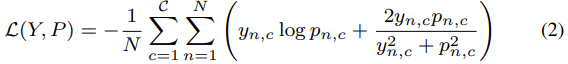

In [ ]:
class MixedLoss(nn.Module):
    """
    Mixed loss function combining Cross-Entropy Loss and a Dice-like term.

    Equation (2) from the UNet++ paper. It combines:
    1. Cross-Entropy Loss: Measures the difference between predicted probabilities and ground truth labels.
    2. Dice-like Term: Encourages overlap between predictions and ground truth by normalizing their intersection.

    Parameters:
        None

    Example:
        >>> loss_fn = MixedLoss()
        >>> y_pred_logits = torch.randn(8, 10, 128, 128)  # [batch_size, num_classes, height, width]
        >>> y_true = torch.randint(0, 10, (8, 128, 128))  # [batch_size, height, width]
        >>> loss = loss_fn(y_pred_logits, y_true)
        >>> print(loss)
    """

    def __init__(self):
        """
        Initializes the MixedLoss class with a CrossEntropyLoss instance.
        """
        super(MixedLoss, self).__init__()
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, y_pred_logits, y_true):
        """
        Computes the mixed loss as described in Equation (2).

        Args:
            y_pred_logits (torch.Tensor): Predicted logits of shape [batch_size, num_classes].
            y_true (torch.Tensor): Ground truth labels of shape [batch_size].

        Returns:
            torch.Tensor: The computed mixed loss.
        """
        smooth = 1e-6

        # Cross-Entropy Loss Term
        ce_loss = self.cross_entropy(y_pred_logits, y_true)

        # Compute Dice-like Term
        y_pred_softmax = F.softmax(y_pred_logits, dim=1)  # Shape: [batch_size, num_classes]
        y_true_one_hot = F.one_hot(y_true, num_classes=y_pred_logits.size(1)).float()  # Shape: [batch_size, num_classes]

        intersection = (y_pred_softmax * y_true_one_hot).sum(dim=0)  # Sum over batch
        denominator = (y_pred_softmax.pow(2) + y_true_one_hot.pow(2)).sum(dim=0) + smooth
        dice_score = (2 * intersection + smooth) / denominator

        dice_loss = 1 - dice_score.mean()

        return ce_loss + dice_loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetPlusPlus(in_channels=1, out_channels=10).to(device)
criterion = MixedLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 3
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        # Output Shape:
        # For classification tasks: [batch_size, num_classes].
        # For segmentation tasks: [batch_size, num_classes, height, width].

        # Removes spatial dimensions from outputs using global average pooling (adaptive_avg_pool2d).
        outputs_pooled = F.adaptive_avg_pool2d(outputs, (1, 1)).squeeze(-1).squeeze(-1)  # (batch_size, num_classes)
        loss = criterion(outputs_pooled, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}")


Epoch [1/3], Loss: 0.7870
Epoch [2/3], Loss: 0.1767
Epoch [3/3], Loss: 0.1379


In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            outputs_pooled = F.adaptive_avg_pool2d(outputs, (1, 1)).squeeze(-1).squeeze(-1)

            loss = criterion(outputs_pooled, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs_pooled, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy = correct / total * 100

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

evaluate(model, test_loader, criterion, device)

Test Loss: 0.0736, Test Accuracy: 98.75%


(0.0736371564697491, 98.75)

In [ ]:
def infer(model, image, device):
    model.eval()  # 평가 모드

    # Converts an image tensor of shape [channels, height, width] to [batch_size=1, channels, height, width]
    image = image.unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(image)
        outputs_pooled = F.adaptive_avg_pool2d(outputs, (1, 1)).squeeze(-1).squeeze(-1)

        # 클래스 예측
        _, predicted_class = torch.max(outputs_pooled, dim=1)

    return predicted_class.item()

# 예시 추론 코드
sample_image, sample_label = test_dataset[0]
predicted_class = infer(model, sample_image.to(device), device)
print(f"True Label: {sample_label}, Predicted Label: {predicted_class}")

True Label: 7, Predicted Label: 7


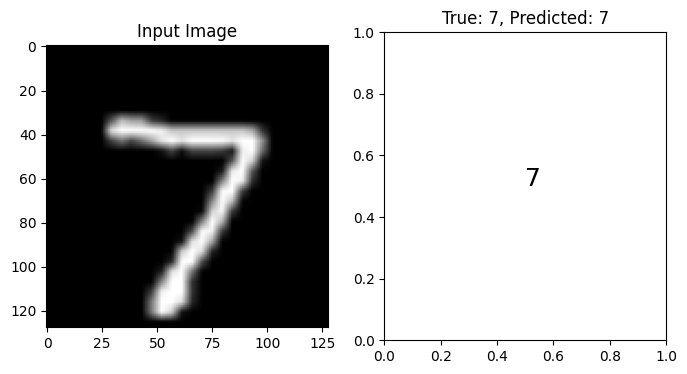

In [ ]:
import matplotlib.pyplot as plt

def visualize_prediction(image, label, prediction):
    plt.figure(figsize=(8, 4))

    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(image.squeeze(), cmap='gray')

    plt.subplot(1, 2, 2)
    plt.title(f"True: {label}, Predicted: {prediction}")
    plt.text(0.5, 0.5, str(prediction), fontsize=18)

    plt.show()

visualize_prediction(sample_image.cpu(), sample_label, predicted_class)

## **Errors Encountered and Fixes**

#### **1. CrossEntropyLoss Dimension Mismatch**
- **Error Message**:
  ```
  RuntimeError: only batches of spatial targets supported (3D tensors) but got targets of size: [32]
  ```
- **Cause**:
  The `CrossEntropyLoss` function expects the target (`labels`) to be a **1D tensor** of size `[batch_size]` for classification tasks or a **3D tensor** for segmentation tasks (e.g., `[batch_size, height, width]`). However, the `MixedLoss` implementation was designed for segmentation tasks, where both predictions and targets are pixel-wise.
- **Fix**:
  - Modified `MixedLoss` to handle classification logits (`[batch_size, num_classes]`) and integer class labels (`[batch_size]`) directly.
  - Removed spatial operations like `adaptive_avg_pool2d`.

---

#### **2. Dimension Mismatch in One-Hot Encoding**
- **Error Message**:
  ```
  RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 4
  ```
- **Cause**:
  The `F.one_hot()` function returns a **2D tensor** (`[batch_size, num_classes]`) for classification tasks, but the code attempted to permute it as if it were a **4D tensor**, causing a dimension mismatch.
- **Fix**:
  - Adjusted Dice Loss calculation to work with MNIST’s classification labels.
  - Removed unnecessary spatial dimensions and ensured compatibility with classification tasks.

---

#### **3. Scalar Conversion Error in Inference**
- **Error Message**:
  ```
  RuntimeError: a Tensor with X elements cannot be converted to Scalar
  ```
- **Cause**:
  The inference code attempted to convert a multi-dimensional tensor into a scalar using `.item()`. This happened because the model output retained spatial dimensions instead of being reduced to class probabilities.
- **Fix**:
  - Used `F.adaptive_avg_pool2d(outputs, (1, 1))` to remove spatial dimensions.
  - Ensured that the output shape was `[batch_size, num_classes]` before extracting the predicted class.

---

#### **4. Dice Loss Denominator Mismatch**
- **Error Message**:
  ```
  IndexError: Dimension out of range (expected to be in range of [-2, 1], but got X)
  ```
- **Cause**:
  The Dice Loss implementation used incorrect dimensions for summation. Specifically, it attempted to sum over non-existent spatial dimensions in tensors meant for classification tasks.
- **Fix**:
  - For classification tasks, adjusted Dice Loss to sum over batch dimensions only (`dim=0`).
  - For segmentation tasks, retained summation over batch and spatial dimensions (`dim=(0, 2, 3)`).

---


